<a href="https://www.kaggle.com/code/muhammadareebkhan/news-headlines-sarcasam-detection?scriptVersionId=132501540" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## DATA SET DISCRIPTION

The dataset I am using is available at the Kaggle link:https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection, is called the "News Headlines Dataset for Sarcasm Detection." It is a collection of news headlines that have been labeled to indicate whether they are sarcastic or not.

The dataset contains two files: "Sarcasm_Headlines_Dataset.json" and "Sarcasm_Headlines_Dataset_v2.json". The first file is the original version of the dataset, while the second file is an updated version with more data.

Each file contains records in JSON format, where each record represents a news headline along with its label. The records consist of three key-value pairs: "headline," "article_link," and "is_sarcastic." The "headline" key stores the text of the news headline, the "article_link" key contains the URL of the original article, and the "is_sarcastic" key indicates whether the headline is sarcastic (1) or not (0).

The dataset is designed to facilitate the task of sarcasm detection in news headlines, which is a challenging problem in natural language processing. It can be used for various purposes, such as training and evaluating machine learning models or conducting research on sarcasm detection algorithms.

By utilizing this dataset, you can develop models or algorithms to automatically identify sarcasm in news headlines, contributing to the advancement of natural language understanding and sentiment analysis.

   ![](https://leadx.org/wp-content/uploads/2017/05/sarcasm-2015186_1920-696x430.jpg)

## IMPORTS

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from unidecode import unidecode

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

import collections
import re
import os
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## I am Using Kaggle NoteBook So i just added the Data.

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.100d.txt


## Read into DataFrame

In [3]:
address = "/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json"
json_df = pd.read_json(address,lines = True )
df = pd.DataFrame(json_df)

## EDA

In [4]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
df.tail()

,is_sarcastic,headline,article_link
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...
28618,1,dad clarifies this not a food stop,https://www.theonion.com/dad-clarifies-this-no...


## The article_link column is not usefull so lets just drop it.

In [6]:
df = df.drop("article_link", axis = 1)

In [7]:
df.columns

Index(['is_sarcastic', 'headline'], dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [9]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [10]:
df.shape

(28619, 2)

In [11]:
df.isna().sum()

is_sarcastic    0
headline        0
dtype: int64

## Checking For Duplicate Values

In [12]:
df.duplicated().sum()

116

## So Our data has some Duplicates Lets Drop them

In [13]:
df.drop_duplicates(subset=['headline'], inplace = True)
df.duplicated().sum()

0

In [14]:
df.describe(include = 'all')

,is_sarcastic,headline
count,28503.000000,28503
unique,NaN,28503
top,NaN,thirtysomething scientists unveil doomsday clo...
freq,NaN,1
mean,0.475459,NaN
std,0.499406,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,1.000000,NaN


In [15]:
df['headline'][10]

'this lesbian is considered a father in indiana (and an amazing one at that)'

## VISUALIZING THE DATA

### Ploting the is_sarcastic data to analyze positive and negative counts.

<AxesSubplot: xlabel='is_sarcastic', ylabel='count'>

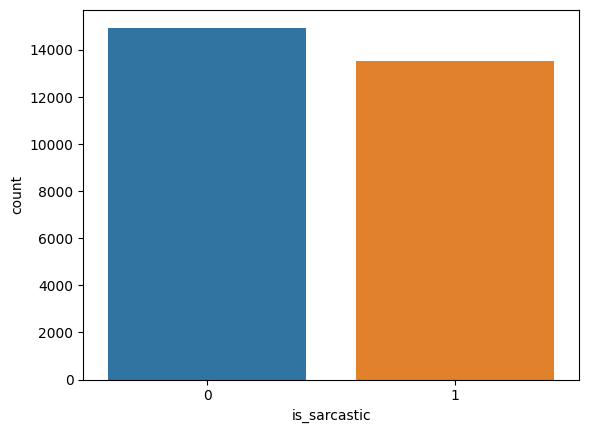

In [16]:
sns.countplot(x = "is_sarcastic", data = df)

### Let's check the length of the texts.

Text(0.5, 1.0, 'Not Sarcastic text length')

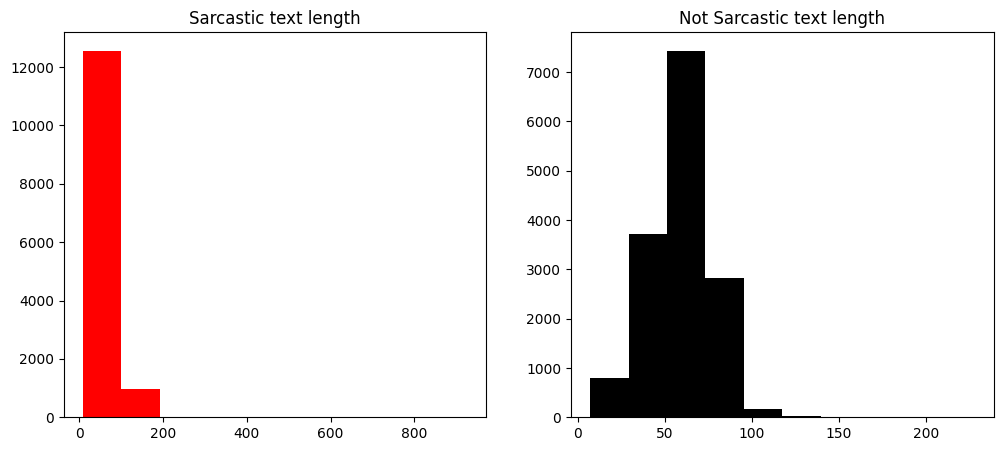

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
text_len=df[df['is_sarcastic']==1]['headline'].apply(len)
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text length')
text_len=df[df['is_sarcastic']==0]['headline'].apply(len)
ax2.hist(text_len,color='black')
ax2.set_title('Not Sarcastic text length')

## Let's check the word count of the texts.

Text(0.5, 1.0, 'Not Sarcastic text word count')

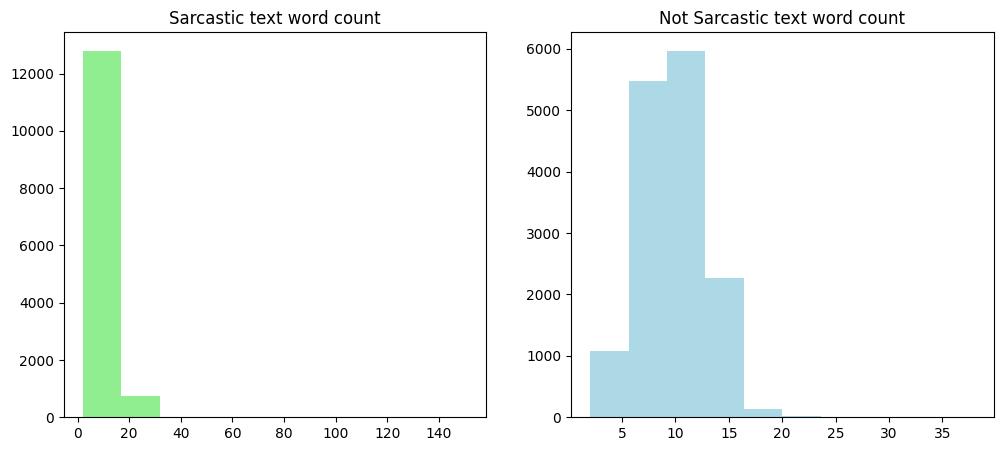

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='lightgreen')
ax1.set_title('Sarcastic text word count')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='lightblue')
ax2.set_title('Not Sarcastic text word count')

Text(0.5, 1.0, 'Not Sarcastic average word length')

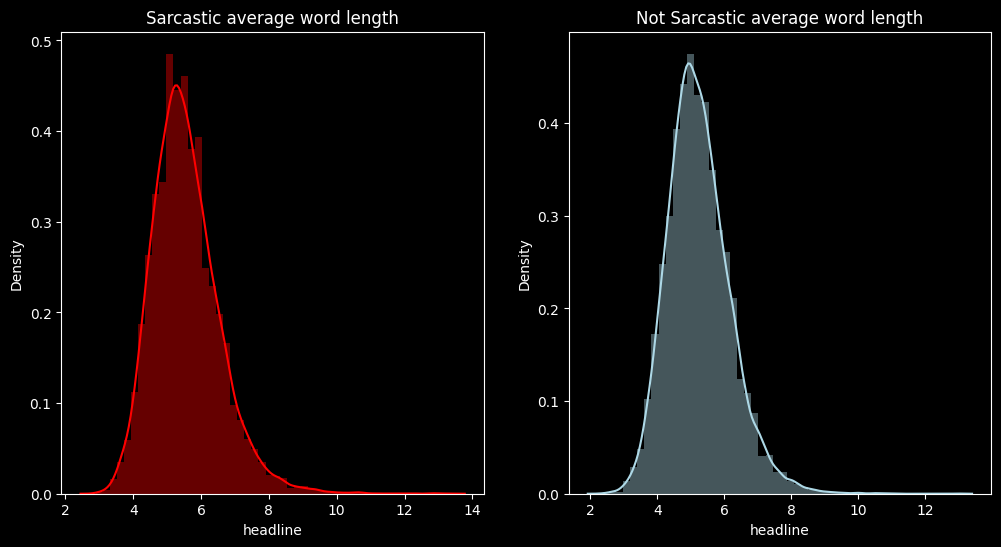

In [19]:
plt.style.use('dark_background')
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic average word length')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='lightblue')
ax2.set_title('Not Sarcastic average word length')

# **PREPROCESSING**

## DATA CLEANING

In [20]:
df['cleaned_headline'] = df['headline'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x.lower()))
df['cleaned_headline'] = df['cleaned_headline'].apply(lambda x: re.sub('\s+', ' ', x).strip())
print(df['cleaned_headline'])

0        thirtysomething scientists unveil doomsday clo...
1        dem rep totally nails why congress is falling ...
2           eat your veggies deliciously different recipes
3        inclement weather prevents liar from getting t...
4        mother comes pretty close to using word stream...
                               ...                        
28614         jews to celebrate rosh hashasha or something
28615    internal affairs investigator disappointed con...
28616    the most beautiful acceptance speech this week...
28617    mars probe destroyed by orbiting spielberggate...
28618                   dad clarifies this not a food stop
Name: cleaned_headline, Length: 28503, dtype: object


In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Tokenization, stopword removal, stemming, and joining

In [22]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

df['final_text'] = df['cleaned_headline'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x.lower()) if word not in stop_words]))
df['final_text']

0        thirtysometh scientist unveil doomsday clock h...
1        dem rep total nail congress fall short gender ...
2                            eat veggi delici differ recip
3                  inclement weather prevent liar get work
4         mother come pretti close use word stream correct
                               ...                        
28614                      jew celebr rosh hashasha someth
28615    intern affair investig disappoint conspiraci d...
28616          beauti accept speech week came queer korean
28617       mar probe destroy orbit spielbergg space palac
28618                                dad clarifi food stop
Name: final_text, Length: 28503, dtype: object

## TOP 10 MOST USED WORDS BEFORE CLEANING AND PREPROCESSING

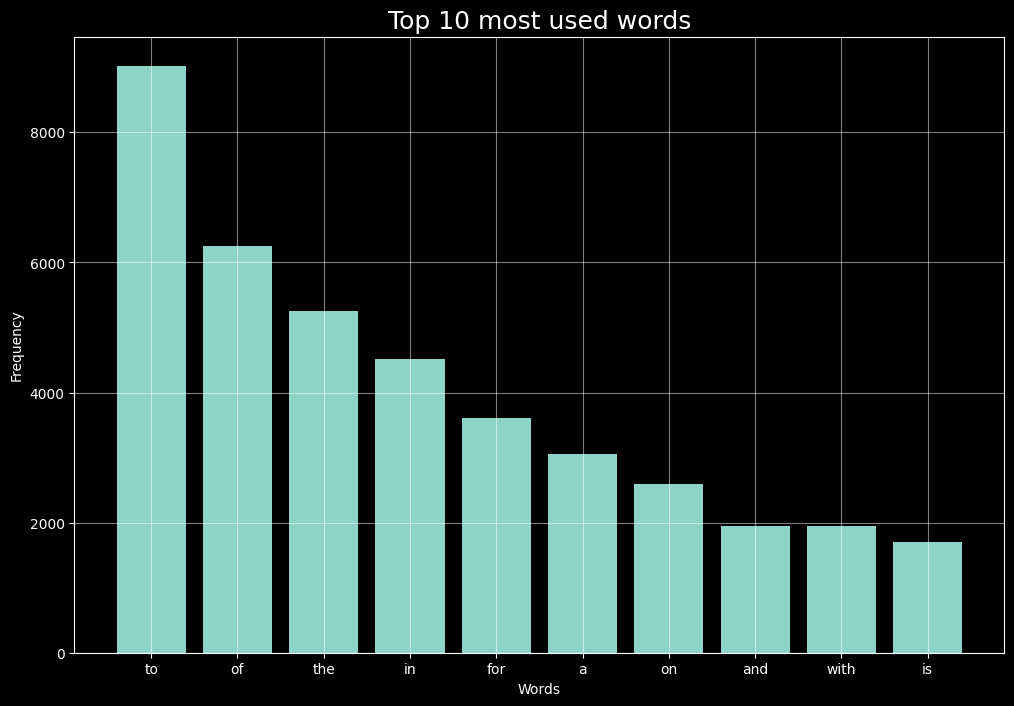

In [23]:
words = []
for text in df['headline']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))
plt.style.use('dark_background')
plt.figure(figsize = (12, 8))
plt.bar(range(len(top_words)), list(top_words.values()), align='center')
plt.xticks(range(len(top_words)), list(top_words.keys()))
plt.grid(alpha = 0.5)
plt.title('Top 10 most used words', fontsize = 18)
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.show()

## TOP 10 MOST USED WORDS AFTER CLEANING AND PREPROCESSING

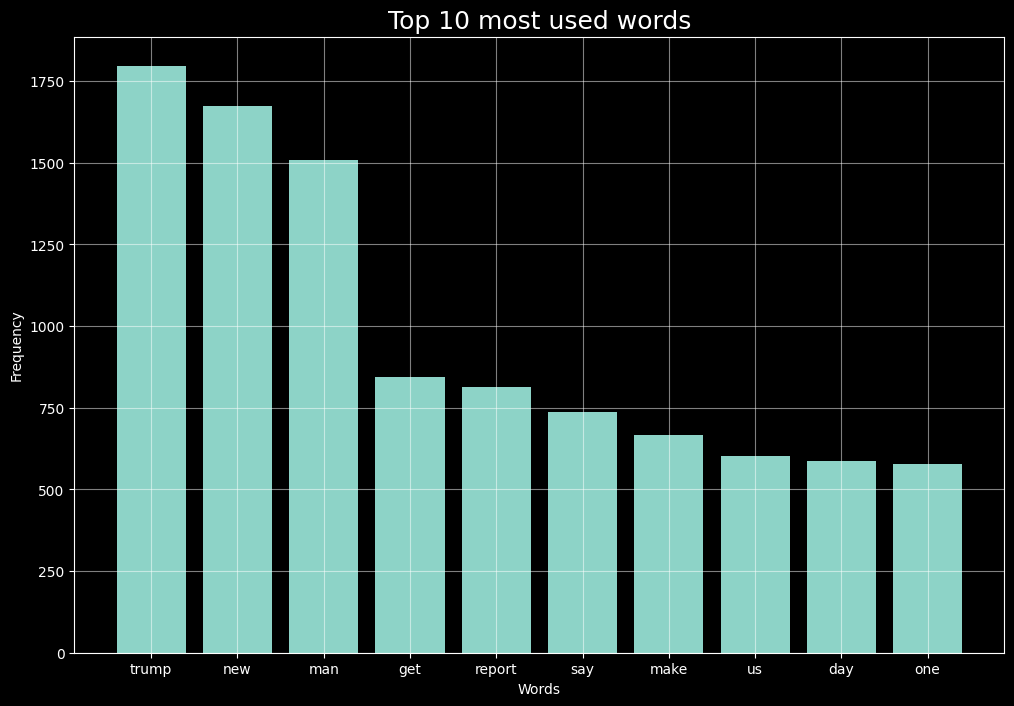

In [24]:
words = []
for text in df['final_text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))
plt.style.use('dark_background')
plt.figure(figsize = (12, 8))
plt.bar(range(len(top_words)), list(top_words.values()), align='center')
plt.xticks(range(len(top_words)), list(top_words.keys()))
plt.grid(alpha = 0.5)
plt.title('Top 10 most used words', fontsize = 18)
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.show()

Now we see there is a clear change that is now the text is preprocessed cleaned and free from stopwords and other special characters and stuff

## LABEL AND SENTENCES

In [25]:
labels = np.array(df.is_sarcastic)
sentences = np.array(df.final_text)
print('Number of sentences and labels: ', len(labels), len(sentences))

Number of sentences and labels:  28503 28503


In [26]:
sentences

array(['thirtysometh scientist unveil doomsday clock hair loss',
       'dem rep total nail congress fall short gender racial equal',
       'eat veggi delici differ recip', ...,
       'beauti accept speech week came queer korean',
       'mar probe destroy orbit spielbergg space palac',
       'dad clarifi food stop'], dtype=object)

In [27]:
labels

array([1, 0, 0, ..., 0, 1, 1])

## WORD GRAPH

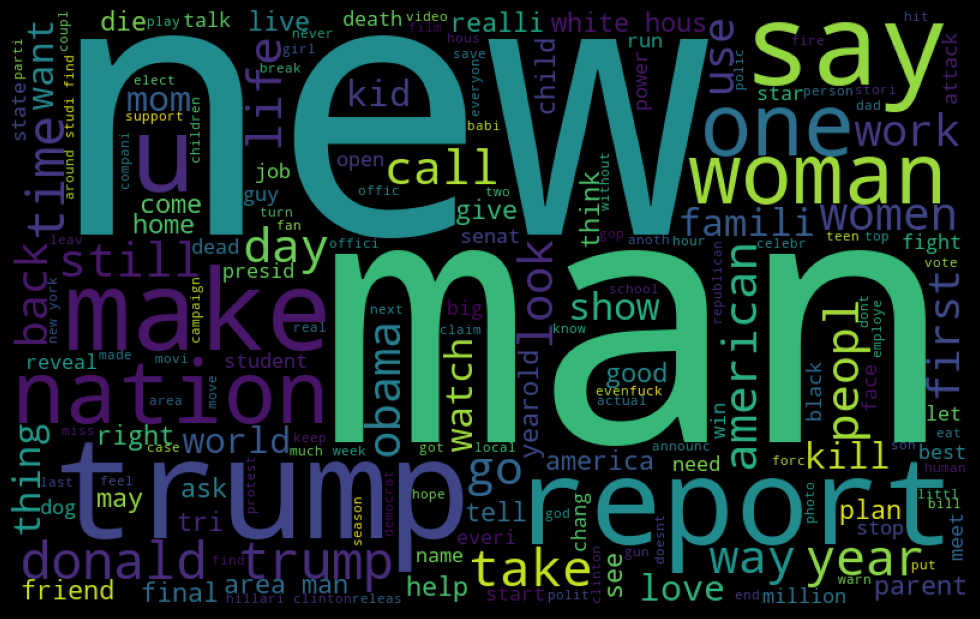

In [28]:
text = ' '.join(caption for caption in df['final_text'])

wordcloud = WordCloud(width = 800, height = 500, background_color = 'black', 
                min_font_size = 10).generate(text)

plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

## WORD GRAPH FOR SARCASTIC AND NON SARCASTIC HEADLINES

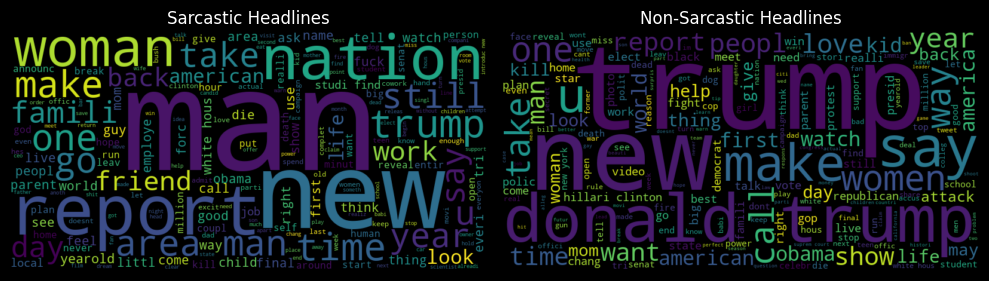

In [29]:
sarcastic_text = ' '.join(df[df['is_sarcastic'] == 1]['final_text'])
non_sarcastic_text = ' '.join(df[df['is_sarcastic'] == 0]['final_text'])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
wordcloud_sarcastic = WordCloud(width=800, height=400).generate(sarcastic_text)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Headlines')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_non_sarcastic = WordCloud(width=800, height=400).generate(non_sarcastic_text)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Headlines')
plt.axis('off')

plt.tight_layout()
plt.show()

## Sarcastic and Non Sarcastic Headline Lengths

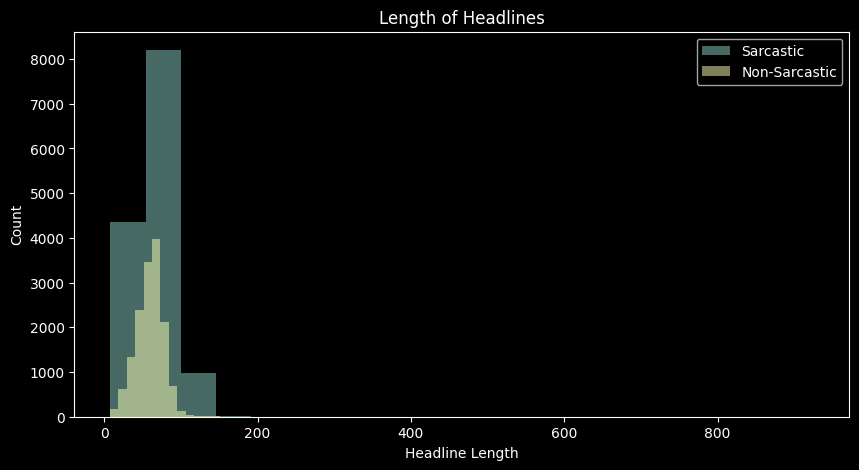

In [30]:
df['headline_length'] = df['headline'].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(df[df['is_sarcastic'] == 1]['headline_length'], bins=20, alpha=0.5, label='Sarcastic')
plt.hist(df[df['is_sarcastic'] == 0]['headline_length'], bins=20, alpha=0.5, label='Non-Sarcastic')
plt.xlabel('Headline Length')
plt.ylabel('Count')
plt.legend()
plt.title('Length of Headlines')
plt.show()

# TRAIN TEST SPLIT

In [31]:
x_train, x_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2)
print('Train and Test set distribution: ', len(x_train), len(x_test), len(y_train), len(y_test))

Train and Test set distribution:  22802 5701 22802 5701


In [32]:
vocab_size = 10000
max_length = 32
embedding_dim = 32
padding_type='post'
oov_token = '<OOV>'

In [33]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [34]:
# print(word_index)

## Padding

In [35]:
train_sequences = tokenizer.texts_to_sequences(x_train)
padded_train_sequences = pad_sequences(train_sequences, maxlen = max_length, padding = padding_type)

test_sequences = tokenizer.texts_to_sequences(x_test)
padded_test_sentences = pad_sequences(test_sequences, maxlen = max_length, padding = padding_type)

## USING GLOVE EMBEDDINGS
you can download them from here LINK: https://nlp.stanford.edu/projects/glove/

In [36]:
embedding_dim = 100

# Load pre-trained GloVe embeddings
embeddings_index = {}
with open('/kaggle/input/glove6b/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

# Create an embedding matrix
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define the model architecture

In [37]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [38]:
# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# Compile the model

In [39]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001  # Specify your desired learning rate

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           1781200   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,823,505
Trainable params: 42,305
Non-trainable params: 1,781,200
_________________________________________________________________


# Train the model

In [41]:
history = model.fit(padded_train_sequences, y_train, epochs=10, validation_data=(padded_test_sentences, y_test), batch_size=32)

Epoch 1/10
713/713 [==============================] - 12s 7ms/step - loss: 0.6129 - accuracy: 0.6641 - val_loss: 0.5586 - val_accuracy: 0.7148
Epoch 2/10
713/713 [==============================] - 5s 6ms/step - loss: 0.5349 - accuracy: 0.7381 - val_loss: 0.5029 - val_accuracy: 0.7550
Epoch 3/10
713/713 [==============================] - 5s 7ms/step - loss: 0.4866 - accuracy: 0.7659 - val_loss: 0.4881 - val_accuracy: 0.7614
Epoch 4/10
713/713 [==============================] - 5s 6ms/step - loss: 0.4521 - accuracy: 0.7884 - val_loss: 0.4765 - val_accuracy: 0.7706
Epoch 5/10
713/713 [==============================] - 4s 6ms/step - loss: 0.4181 - accuracy: 0.8073 - val_loss: 0.4684 - val_accuracy: 0.7771
Epoch 6/10
713/713 [==============================] - 5s 6ms/step - loss: 0.3893 - accuracy: 0.8240 - val_loss: 0.4779 - val_accuracy: 0.7711
Epoch 7/10
713/713 [==============================] - 4s 6ms/step - loss: 0.3624 - accuracy: 0.8403 - val_loss: 0.5322 - val_accuracy: 0.7730
Epoch

## EVALUATION

In [42]:
def plot_graphs(history, string):
    plt.style.use('seaborn')
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

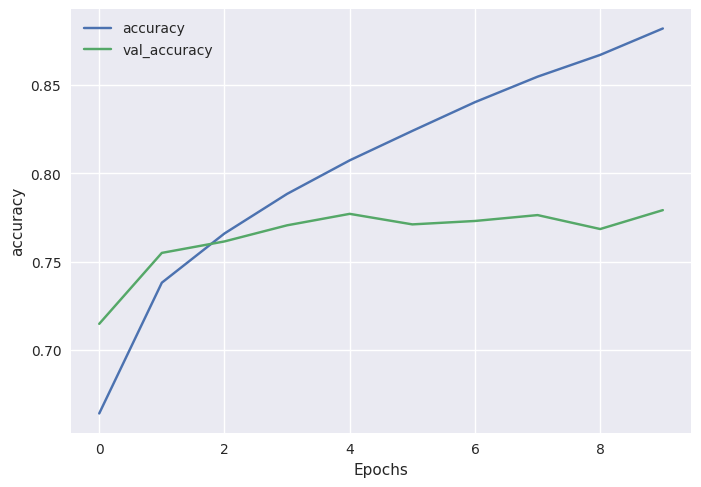

In [43]:
plot_graphs(history, "accuracy")

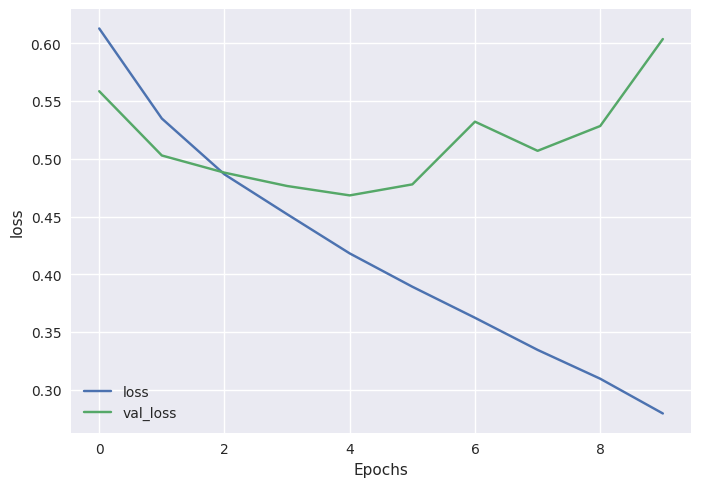

In [44]:
plot_graphs(history, "loss")

In [45]:
print('Accuracy on test set: ', model.evaluate(padded_test_sentences,y_test)[1]*100)

179/179 [==============================] - 1s 3ms/step - loss: 0.6038 - accuracy: 0.7792
Accuracy on test set:  77.91615724563599


In [46]:
preds = model.predict(padded_test_sentences).flatten()
y_predict = []
for i in preds:
    if i < 0.5:
        y_predict.append(0)
    else:
        y_predict.append(1)
y_predict[:5]

179/179 [==============================] - 1s 2ms/step


[1, 0, 1, 0, 1]

## CLASSIFICATION REPORT

In [47]:
print(classification_report(y_test, y_predict, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.81      0.76      0.78      3001
    Sarcastic       0.75      0.80      0.77      2700

     accuracy                           0.78      5701
    macro avg       0.78      0.78      0.78      5701
 weighted avg       0.78      0.78      0.78      5701



## Confusion Matrix

In [48]:
cm = confusion_matrix(y_test,y_predict)
print(cm)

[[2294  707]
 [ 552 2148]]


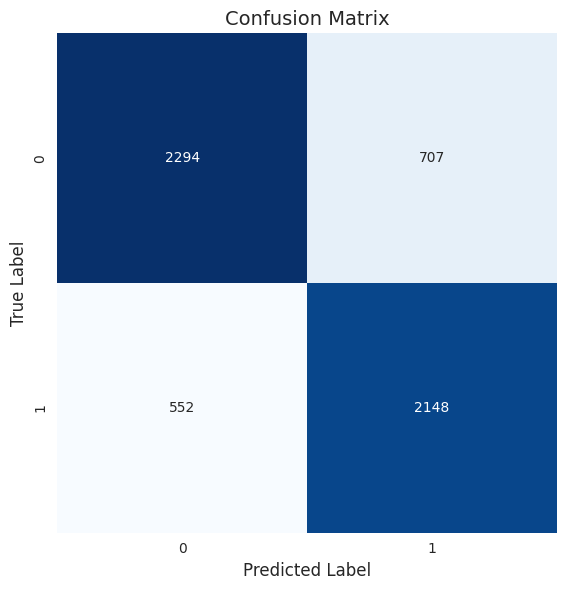

In [49]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
heatmap.set_xlabel('Predicted Label', fontsize=12)
heatmap.set_ylabel('True Label', fontsize=12)
heatmap.set_title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

## Using the model on a Sentence

## Make predictions

In [53]:
new_sentence = "Groundbreaking Study Reveals That Water is Actually Wet."
# Preprocess the new sentence
new_sequence = tokenizer.texts_to_sequences([new_sentence])
padded_new_sequence = pad_sequences(new_sequence, maxlen=max_length, padding=padding_type)
predictions = model.predict(padded_new_sequence)
labels = ['Not Sarcastic', 'Sarcastic']
predicted_label = labels[int(round(predictions[0][0]))]
print(f"The Sentence Is '{new_sentence}' is: {predicted_label}")

1/1 [==============================] - 0s 20ms/step
The Sentence Is 'Groundbreaking Study Reveals That Water is Actually Wet.' is: Sarcastic


In [54]:
new_sentence = "Scientists Make Significant Progress in Developing a Cure for Cancer"
# Preprocess the new sentence
new_sequence = tokenizer.texts_to_sequences([new_sentence])
padded_new_sequence = pad_sequences(new_sequence, maxlen=max_length, padding=padding_type)
predictions = model.predict(padded_new_sequence)
labels = ['Not Sarcastic', 'Sarcastic']
predicted_label = labels[int(round(predictions[0][0]))]
print(f"The Sentence Is '{new_sentence}' is: {predicted_label}")

1/1 [==============================] - 0s 23ms/step
The Sentence Is 'Scientists Make Significant Progress in Developing a Cure for Cancer' is: Not Sarcastic
